<a href="https://colab.research.google.com/github/tgrappoport/2dmat/blob/master/7_TMDs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook uses the 3 bands model for transition metal dichalcogenides (TMDs), presented in reference https://doi.org/10.1103/PhysRevB.88.085433. We consider TMDs  without spin-orbit coupling (provided as a repository in pybinding) and with spin-orbit coupling (provided here).

We first install kite and pybinding and import the libraries.

In [ ]:
%%capture --no-display
!pip install h5py==3.11.0
!pip install -i https://test.pypi.org/simple/ pybinding quantum-kite==0.0.4


import numpy as np
from math import sqrt, pi
import pybinding as pb
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import kite

# seaborn setting
sns.set(style="ticks")
sns.set_style({"xtick.direction": "in", "ytick.direction": "in"})
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2.5})



To use the pybinding repository for the TMDs we use:

In [ ]:
from pybinding.repository import group6_tmd

First, we select a single TMD layer, like MoS$_2$ and show the triangular tight-binding model, its Brillouin zone and the band structure for a given path in k-space:

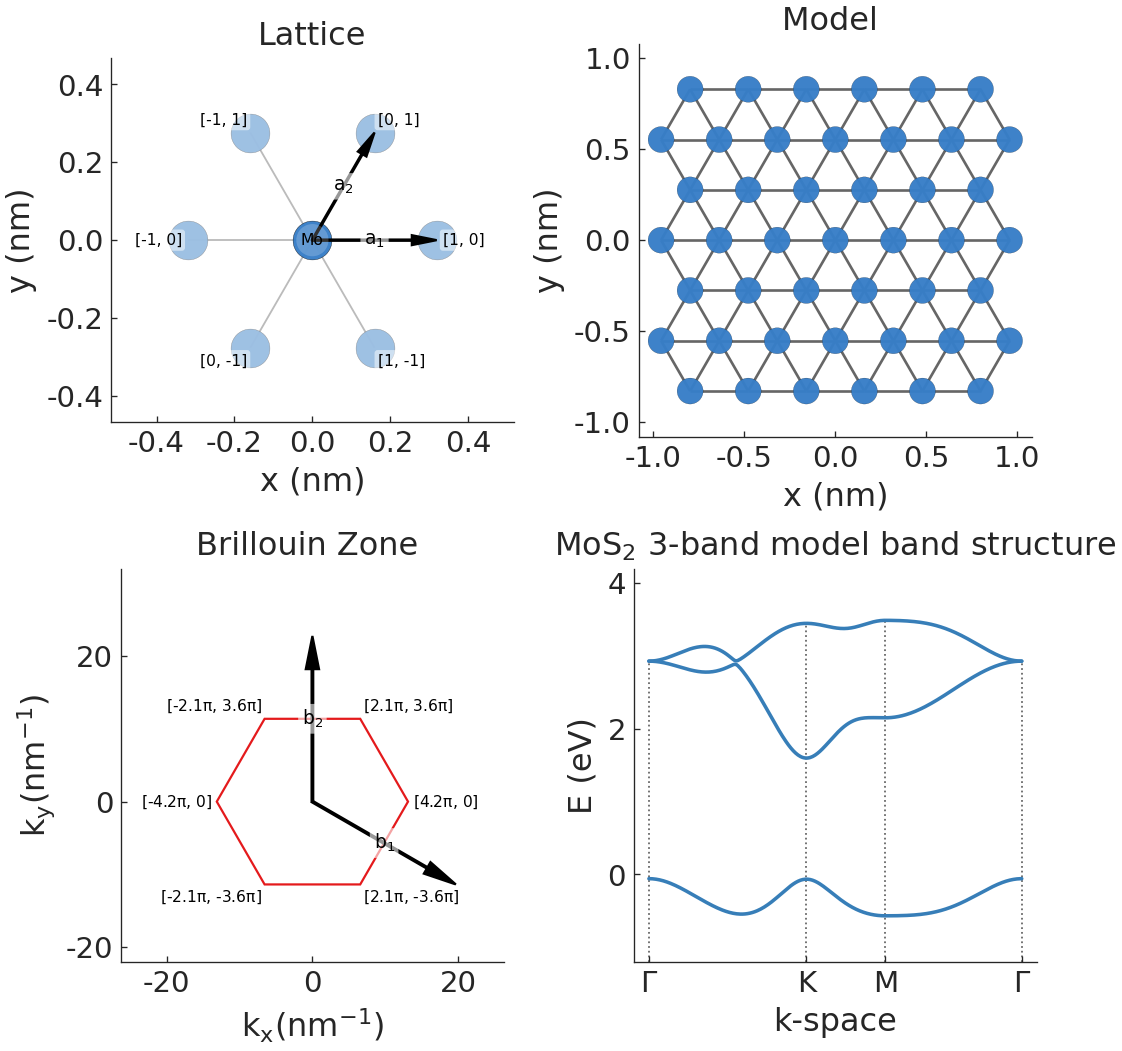

In [ ]:
pb.pltutils.use_style()
lattice=group6_tmd.monolayer_3band("MoS2")
plot=plt.figure(figsize=(6.7, 6.7))
plt.subplot(221, title="Lattice")
lattice.plot()
model = pb.Model(group6_tmd.monolayer_3band("MoS2"), pb.rectangle(2))
plt.subplot(222, title="Model ")
model.plot(hopping={'width': 2, 'cmap': 'auto'})
plt.subplot(223, title="Brillouin Zone ")
lattice.plot_brillouin_zone()

model = pb.Model(group6_tmd.monolayer_3band("MoS2"), pb.translational_symmetry())
solver = pb.solver.lapack(model)
k_points = model.lattice.brillouin_zone()
gamma = [0, 0]
k = k_points[0]
m = (k_points[0] + k_points[1]) / 2

plt.subplot(224, title="MoS$_2$ 3-band model band structure")
bands = solver.calc_bands(gamma, k, m, gamma)
bands.plot(point_labels=[r"$\Gamma$", "K", "M", r"$\Gamma$"])
plt.tight_layout()
plt.show(plot)

We now plot all the band-structure of the TMDs we have:

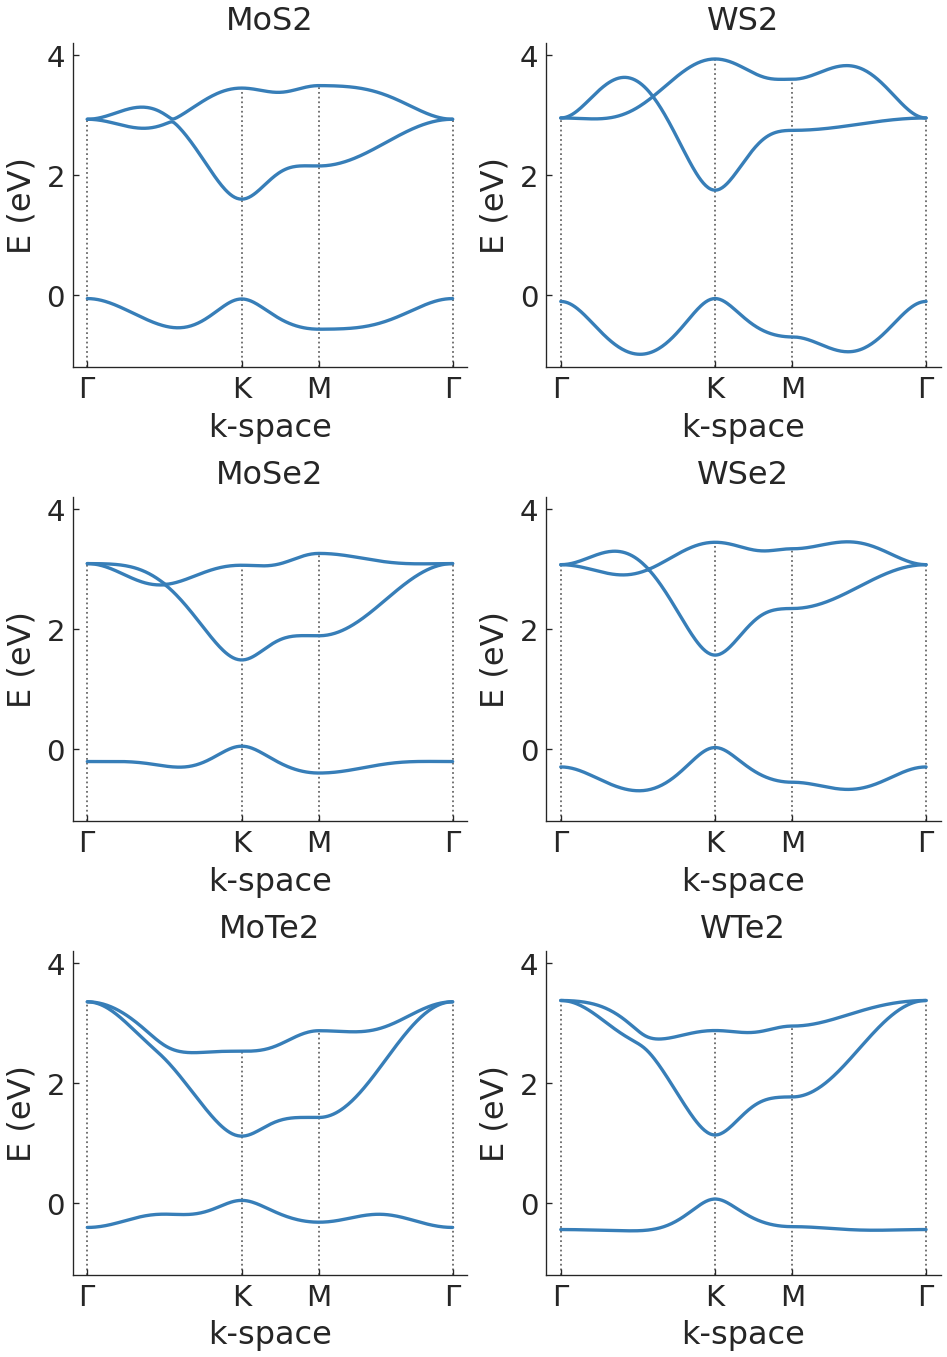

<Figure size 544x467.2 with 0 Axes>

In [ ]:
grid = plt.GridSpec(3, 2, hspace=0.4)
plot2=plt.figure(figsize=(7, 10))

for square, name in zip(grid, ["MoS2", "WS2", "MoSe2", "WSe2", "MoTe2", "WTe2"]):
	model = pb.Model(group6_tmd.monolayer_3band(name), pb.translational_symmetry())
	solver = pb.solver.lapack(model)

	k_points = model.lattice.brillouin_zone()
	gamma = [0, 0]
	k = k_points[0]
	m = (k_points[0] + k_points[1]) / 2

	plt.subplot(square, title=name)
	bands = solver.calc_bands(gamma, k, m, gamma)
	bands.plot(point_labels=[r"$\Gamma$", "K", "M", r"$\Gamma$"], lw=1.5)
plt.show(plot2)
plt.tight_layout()

In this second part, we define a function with the same three bands model but with spin-orbit coupling. It solves the band structure for each spin. Use +1 for spin up and -1 for spin down.

In [ ]:
"""Tight-binding models for group 6 transition metal dichalcogenides (TMD)."""
import re
import math


_default_3band_params = {  # from https://doi.org/10.1103/PhysRevB.88.085433
    # ->           a,  eps1,  eps2,     t0,    t1,    t2,   t11,   t12,    t22   lsoc
    "MoS2":  [0.3190, 1.046, 2.104, -0.184, 0.401, 0.507, 0.218, 0.338,  0.057, 0.073],
    "WS2":   [0.3191, 1.130, 2.275, -0.206, 0.567, 0.536, 0.286, 0.384, -0.061, 0.211],
    "MoSe2": [0.3326, 0.919, 2.065, -0.188, 0.317, 0.456, 0.211, 0.290,  0.130, 0.091],
    "WSe2":  [0.3325, 0.943, 2.179, -0.207, 0.457, 0.486, 0.263, 0.329,  0.034, 0.228],
    "MoTe2": [0.3557, 0.605, 1.972, -0.169, 0.228, 0.390, 0.207, 0.239,  0.252, 0.107],
    "WTe2":  [0.3560, 0.606, 2.102, -0.175, 0.342, 0.410, 0.233, 0.270,  0.190, 0.237],
}


def monolayer_3band_soc1s(name, sz, override_params=None):
    """Monolayer of a group 6 TMD using the nearest-neighbor 3-band model

    Parameters
    ----------
    name : str
        Name of the TMD to model. The available options are: MoS2, WS2, MoSe2,
        WSe2, MoTe2, WTe2. The relevant tight-binding parameters for these
        materials are given by https://doi.org/10.1103/PhysRevB.88.085433.
    override_params : Optional[dict]
        Replace or add new material parameters. The dictionary entries must
        be in the format `"name": [a, eps1, eps2, t0, t1, t2, t11, t12, t22, lsoc]`.

    """
    params = _default_3band_params.copy()
    if override_params:
        params.update(override_params)

    a, eps1, eps2, t0, t1, t2, t11, t12, t22, lsoc = params[name]
    rt3 = math.sqrt(3)  # convenient constant

    lat = pb.Lattice(a1=[a, 0], a2=[1/2 * a, rt3/2 * a])

    metal_name, chalcogenide_name = re.findall("[A-Z][a-z]*", name)
    e0=[[eps1,0,0],
        [0,eps2,2*1j*sz*lsoc],
        [0,-2*1j*sz*lsoc, eps2]
        ]



    lat.add_one_sublattice(metal_name, [0, 0], e0)

    h1 = [[ t0, -t1,   t2],
          [ t1, t11, -t12],
          [ t2, t12,  t22]]


    h2 = [[                    t0,     1/2 * t1 + rt3/2 * t2,     rt3/2 * t1 - 1/2 * t2],
          [-1/2 * t1 + rt3/2 * t2,     1/4 * t11 + 3/4 * t22, rt3/4 * (t11 - t22) - t12],
          [-rt3/2 * t1 - 1/2 * t2, rt3/4 * (t11 - t22) + t12,     3/4 * t11 + 1/4 * t22]]

    h3 = [[                    t0,    -1/2 * t1 - rt3/2 * t2,     rt3/2 * t1 - 1/2 * t2],
          [ 1/2 * t1 - rt3/2 * t2,     1/4 * t11 + 3/4 * t22, rt3/4 * (t22 - t11) + t12],
          [-rt3/2 * t1 - 1/2 * t2, rt3/4 * (t22 - t11) - t12,     3/4 * t11 + 1/4 * t22]]

    m = metal_name
    lat.add_hoppings(([1,  0], m, m, h1),
                     ([0, -1], m, m, h2),
                     ([1, -1], m, m, h3))
    return lat


Here we can see how to use this function. It is necessary to include the name of the TMD and the sign of the spin. To visualize the spin-valley locking, we can plot the two spin configurations in the same plot and use a path that includes both K and K´.

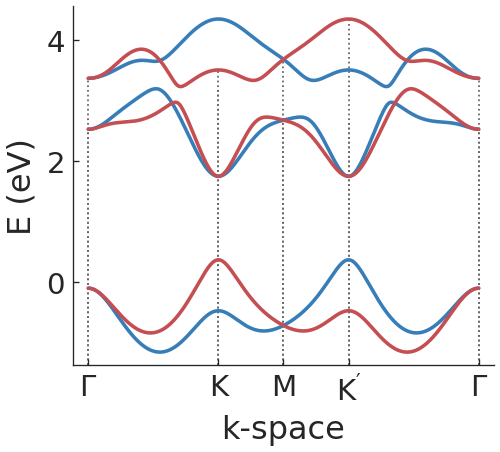

In [ ]:
#monolayer_3band_soc1s("MoS2",1).plot()
model = pb.Model(monolayer_3band_soc1s("WS2",1), pb.translational_symmetry())
solver = pb.solver.lapack(model)
k_points = model.lattice.brillouin_zone()
gamma = [0, 0]
k = k_points[0]
m = (k_points[0] + k_points[1]) / 2
kp = k_points[1]
bands1 = solver.calc_bands(gamma, k, m, kp, gamma)
bands1.plot(point_labels=[r"$\Gamma$", "K", "M", "K$^\prime$",r"$\Gamma$"])
model = pb.Model(monolayer_3band_soc1s("WS2",-1), pb.translational_symmetry())
solver = pb.solver.lapack(model)
bands2 = solver.calc_bands(gamma, k, m, kp, gamma)
bands2.plot(point_labels=[r"$\Gamma$", "K", "M", "K$^\prime$",r"$\Gamma$"],color="r")
plt.show()
